#🔥 주식 예측에 도전해 보자 🔥

STEP 1. 시계열 데이터 준비

STEP 2. 각종 전처리 수행

STEP 3. 시계열 안정성 분석

STEP 4. 학습, 테스트 데이터셋 생성

STEP 5. 적정 ARIMA 모수 찾기

STEP 6. ARIMA 모델 훈련과 테스트

STEP 7 : 다른 주식 종목 예측해 보기


## STEP 1. 시계열 데이터 준비

- 칼럼 종류: Data, Open, High, Low, Close, Adj Close, Volume

- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인

- 종가(Close)만 사용

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

dataset_filepath = '/content/drive/MyDrive/AIFFEL/data/stock_prediction/data/005930.KS.csv'

# index_col=['column_name']으로 설정해주면 날짜/시간을 pandas의 DataFrame의 index로 바로 읽어올 수 있습니다.
# parse_dates=['date'] 처럼 명시적으로 칼럼 이름을 설정하는 방법도 가능
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## STEP 2. 각종 전처리 수행

- 결측치 처리

- 로그 변환

In [2]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

⏳ 이번 데이터에서는 결측치는 없는 것 같다.

⏳ 만약 결측치가 있다면, 두 가지 방법으로 결측치를 처리가 가능하다.

  - 결측치가 있는 데이터를 모두 삭제(drop)

  - 결측치 양옆의 값들을 이용해서 적절히 보간(interpolate)하여 대입  
ex) 2와 4 사이 데이터가 NaN이라면 이 값을 3으로 채우는 방식

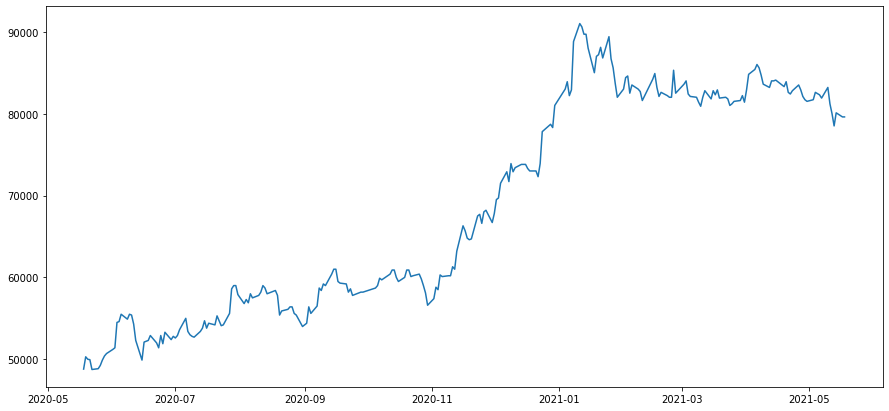

In [3]:
plt.figure(figsize=(15,7))
plt.plot(ts)

⏳ 시간을 index로 가지는 시계열 데이터 같은 경우 삭제하는 것보다는 `보간` 하는 방법으로 Pandas에서 결측치 보간 처리 메서드는 아래와 같다.

Series([], Name: Close, dtype: float64)


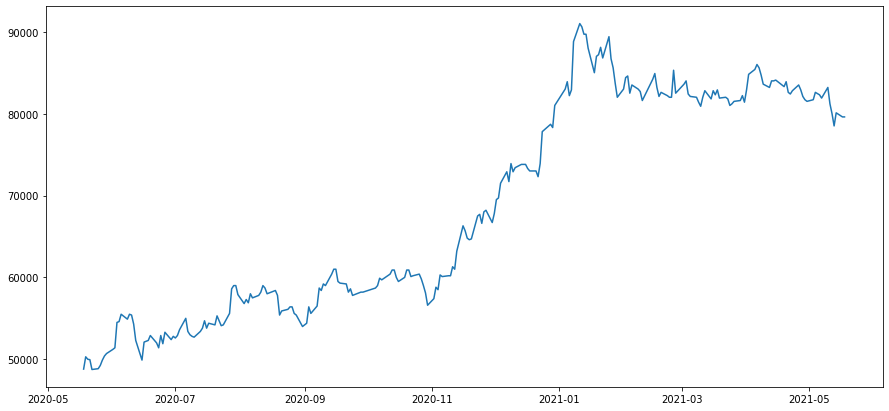

In [4]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts1=ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts1[ts.isna()])

# 다시 그래프를 확인해봅시다!
plt.figure(figsize=(15,7))
plt.plot(ts1)

시간 추이에 따라 일정한 평균, 분산, 자기공분산의 패턴이 나타나는 것 으로 직관적으로 보이게 하지만 큰 변화는 느끼지 못하겠다.

시계열 데이터의 통계적 특성을 좀 더 명료하게 시각화해 보자.

In [5]:
# 로그 변환
ts_log = np.log(ts)

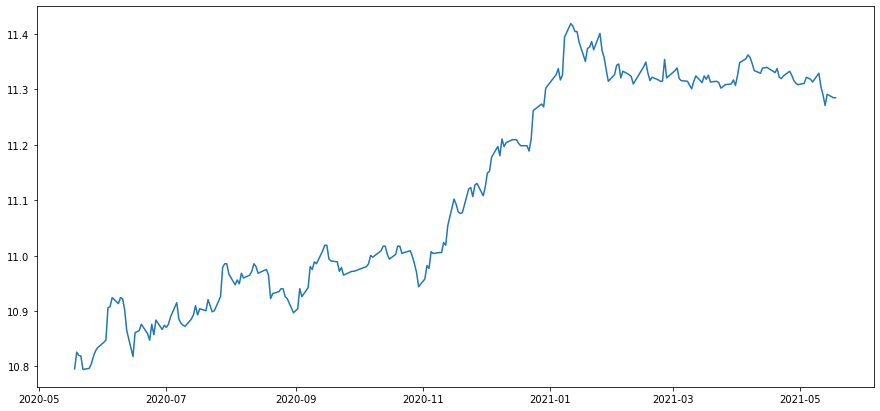

In [6]:
plt.figure(figsize=(15,7))
plt.plot(ts_log)

## STEP 3. 시계열 안정성 분석

- 정성적 그래프 분석

- 정량적 Augmented Dicky-Fuller Test

- 시계열 분해(Time Serise Decomposition)

- Residual 안정성 확인

### ▶ 시계열 안정성의 정성적 분석

아래는 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수이다.

현재 타임 스텝 부터 window에 주어진 타임 스텝 이전 사이

- 구간의 평균(rolling mean, `이동평균`)

- 표준편차(rolling std, `이동표준편차`)


원본 시계열과 함께 **시각화**해 보면 좀 더 뚜렷한 경향성을 확인할 수 있을 것이다.

- [이동평균이란??](https://www.econowide.com/3544)

In [7]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
     # 축을 2개를 사용해서 눈에 잘 보이게 해줌
    ax1 = plt.subplot(111)
    ax2 = ax1.twinx()
    orig, = ax1.plot(timeseries, color='blue',label='Original')    
    mean, = ax1.plot(rolmean, color='red', label='Rolling Mean')
    std, = ax2.plot(rolstd, color='green', label='Rolling Std')
    label = [orig, mean]
    ax1.legend(label, [i.get_label() for i in label], loc=2)
    ax2.legend()
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

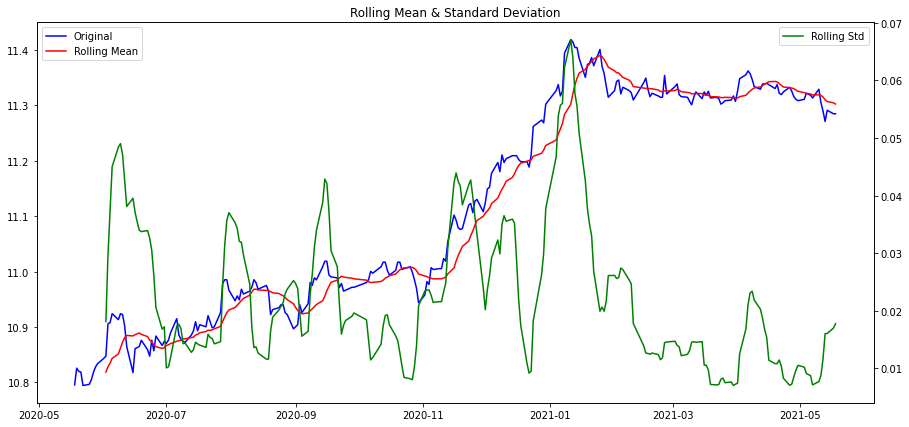

In [8]:
plt.figure(figsize=(15,7))
plot_rolling_statistics(ts_log, window=12)

### ▶ 정량적 Augmented Dickey-Fuller Test

> 1. `주어진 시계열 데이터가 안정적이지 않다라`는 `귀무가설(Null Hypothesis)`를 세운다.   
2. 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우
3. `이 시계열 데이터가 안정적이다`라는 `대립가설(Alternative Hypothesis)`을 채택

In [9]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [10]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


- p-value 가 0에 가깝지 않기때문에 귀무가설은 기각되고, 이 시계열은 안정적 시계열이지 않다.

### ▶ Moving average 제거 - 추세(Trend) 상쇄하기

시계열 분석에서 위와 같이 시간 추이에 따라 나타나는 평균값 변화를 추세(trend)라고 한다.

이 변화량을 제거해 주려면 거꾸로 Moving Average, 즉 rolling mean을 구해서 ts_log에서 빼주자.

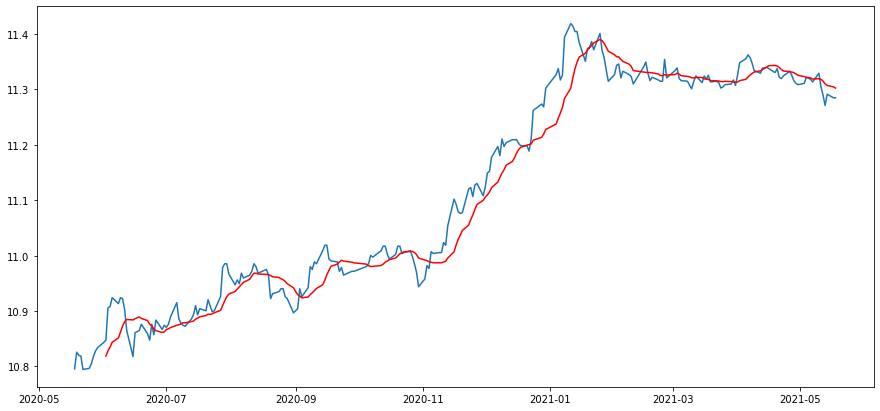

In [11]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.figure(figsize=(15,7))
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [12]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20         NaN
2020-05-21         NaN
2020-05-22         NaN
2020-05-25         NaN
2020-05-26         NaN
2020-05-27         NaN
2020-05-28         NaN
2020-05-29         NaN
2020-06-01         NaN
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
Name: Close, dtype: float64

우리가 관심을 가진 ts_log_moving_avg에 거의 도달하였지만, 문제는 Moving Average 계산 시 (windows size=12인 경우) 앞의 11개의 데이터는 Moving Average가 계산되지 않으므로 ts_log_moving_avg에 결측치(NaN)가 발생한다는 점이다.

이 결측치들은 향후 Dicky-Fuller Test 시에 에러를 발생시킬 것이므로 이를 데이터셋에서 제거해 주자.

In [13]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
2020-06-08    0.061862
2020-06-09    0.061925
2020-06-10    0.049636
2020-06-11    0.021446
2020-06-12   -0.019996
2020-06-15   -0.066141
2020-06-16   -0.025267
2020-06-17   -0.024961
2020-06-18   -0.024494
2020-06-19   -0.010603
2020-06-22   -0.023697
Name: Close, dtype: float64

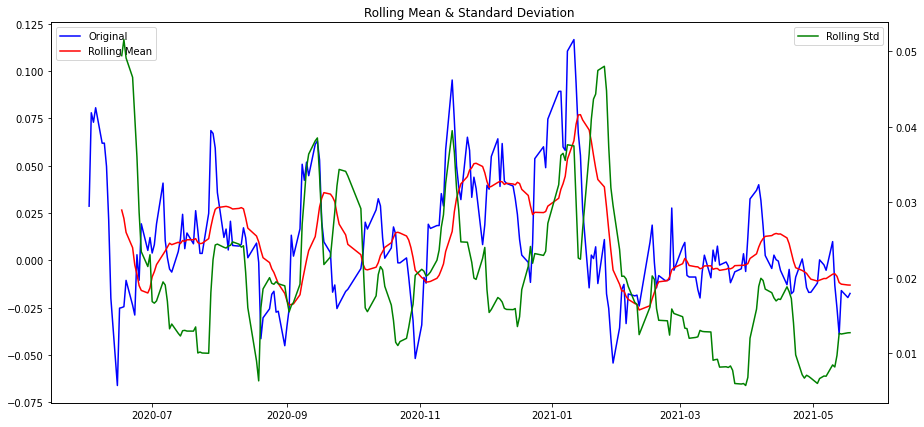

In [14]:
plt.figure(figsize=(15,7))
plot_rolling_statistics(ts_log_moving_avg)

In [15]:
plt.figure(figsize=(15,7))
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -4.163469
p-value                          0.000759
#Lags Used                       0.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


<Figure size 1080x504 with 0 Axes>

✅ p-value가 0.000759이 되었다.

### ▶ 차분(Differencing) - 계절성(Seasonality) 상쇄하기

Trend에는 잡히지 않지만 시계열 데이터 안에 포함된 패턴이 파악되지 않은 주기적 변화는 예측에 방해가 되는 불안정성 요소이다.

이것은 Moving Average 제거로는 상쇄되지 않는 효과다.

이런 계절적, 주기적 패턴을 계절성(Seasonality)라고 한다.

- [시계열 패턴](https://otexts.com/fppkr/tspatterns.html)

이런 패턴을 상쇄하기 위해 효과적인 방법에는 차분(Differencing)이 있다. 

마치 미분(Differentiation)을 떠올리게 하는 개념으로 시계열을 한 스텝 앞으로 시프트한 시계열을 원래 시계열에 빼 주는 방법이다.

이렇게 되면 남은 것은 현재 스텝 값 - 직전 스텝 값이 되어 정확히 이번 스텝에서 발생한 변화량을 의미하게 된다.

🔥 우선 시프트한 시계열과 원본 시계열에 대한 그래프를 그려보자.


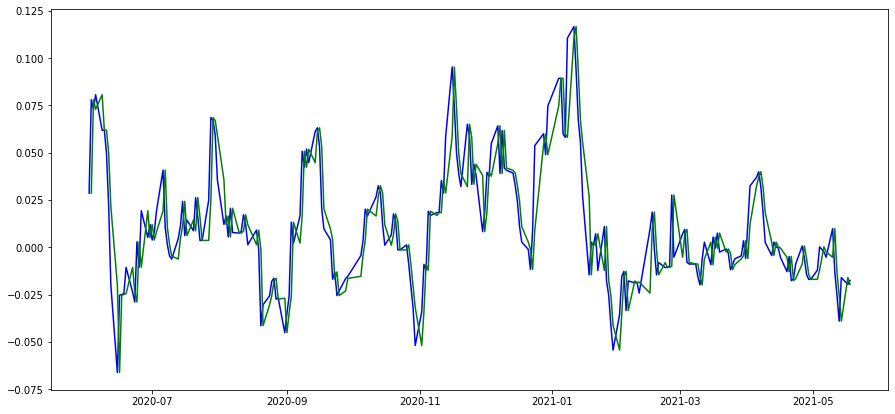

In [16]:
plt.figure(figsize=(15,7))
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

🔥 원본 시계열에서 시프트한 시계열을 뺀 값을 그래프로 그려보자.

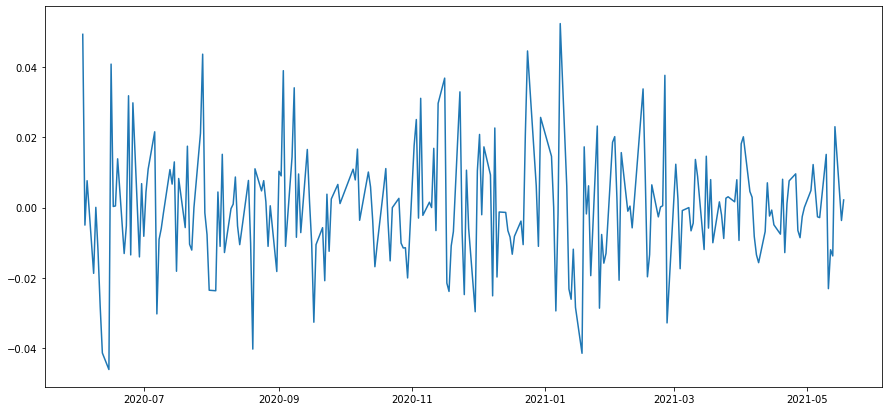

In [17]:
plt.figure(figsize=(15,7))
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

🔥 이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 살펴보자.

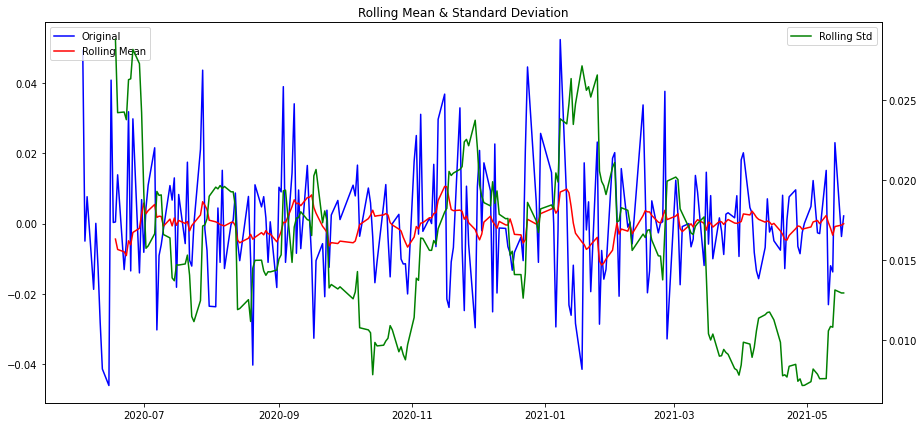

In [18]:
plt.figure(figsize=(15,7))
plot_rolling_statistics(ts_log_moving_avg_diff)

차분의 효과가 어떠했는지 알아보기 위해 Augmented Dickey-Fuller Test를 수행해 보자.

In [19]:
plt.figure(figsize=(15,7))
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.546028e+01
p-value                        2.711476e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


<Figure size 1080x504 with 0 Axes>

이동평균을 빼 주어 추세(Trend)를 제거하고 난 시계열에다가 1차 차분(1st order differencing)을 적용하여 Seasonality 효과를 다소 상쇄한 결과,   
p-value가 0.000759 에서 2.711476e-28 로 줄어들었다.

### ▶ 시계열 분해(Time series decomposition)

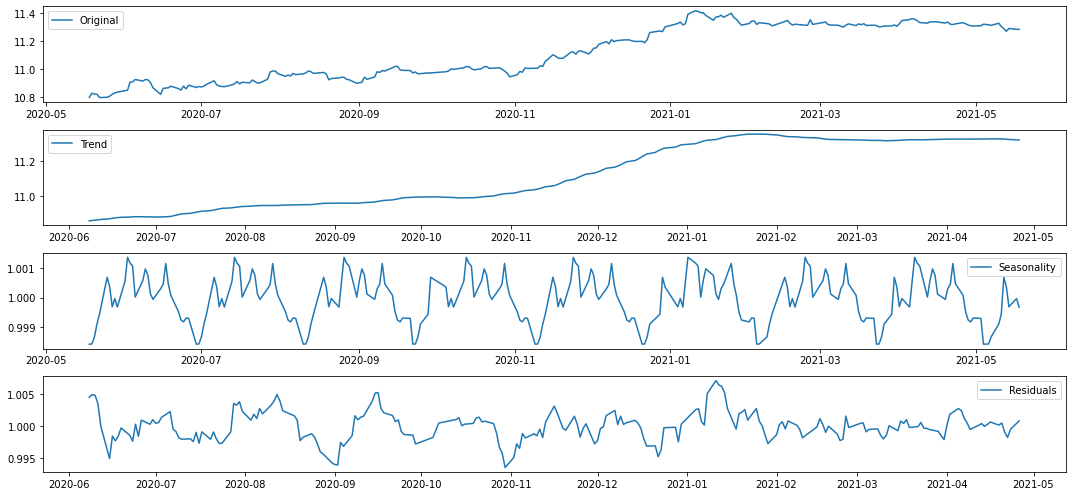

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15,7))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

`Original` 시계열에서 `Trend` 와 `Seasonality` 를 제거하고 난 나머지를 `Residual` 이다. 뒤집어서 말하면 `Trend+Seasonality+Residual=Original` 이 성립한다는 뜻이다.

이러한 `Decomposing` 은 시계열 데이터를 이해하는 중요한 관점을 제시한다.

`Residual` 에 대해 안정성 여부를 따져 보자.

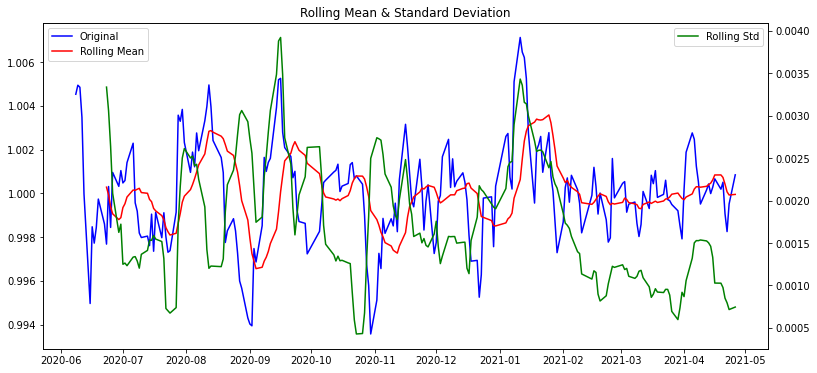

In [21]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [22]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


🔥 p-valur 가 6.234854e-08 로 매우 낮은 것을 알 수 있다.

`Decomposing` 을 통해 얻어진 `Residual` 은 압도적으로 낮은 `p-value` 를 보여준다. 

이 정도면 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있을 것 같다.

## STEP 4. 학습, 테스트 데이터셋 생성



분리 비율은 학습과 테스트에 9:1로 나누자.

시계열 예측이니만큼 가장 나중 데이터를 테스트용으로 사용하는 것이 타당할 것이다.

Train data's length: 225
Test data's length: 25


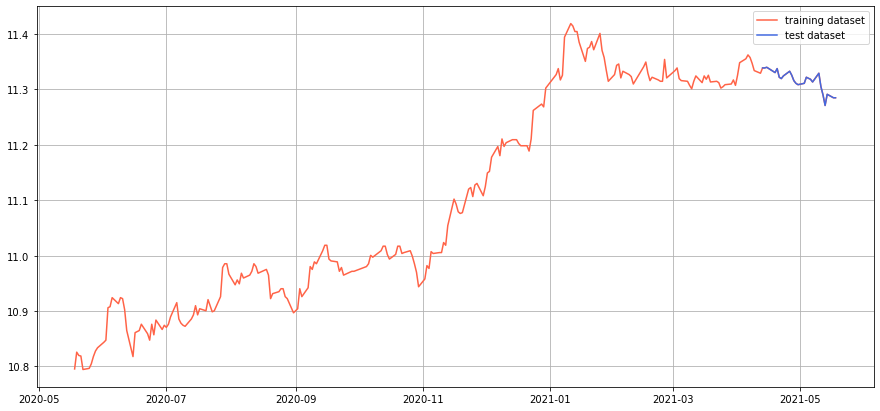

In [23]:
split_idx = int(len(ts_log) * 0.9)
train_data, test_data = ts_log[:split_idx], ts_log[split_idx:]

print(f"Train data's length: {len(train_data)}")
print(f"Test data's length: {len(test_data)}")

fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(ts_log, c='tomato', label='training dataset') ## 전체 데이터셋을 이용해 그리면 자연스럽게 가능.
ax.plot(test_data, c='royalblue', label='test dataset')
ax.grid(True)
ax.legend()

## STEP 5. 적정 ARIMA 모수 찾기

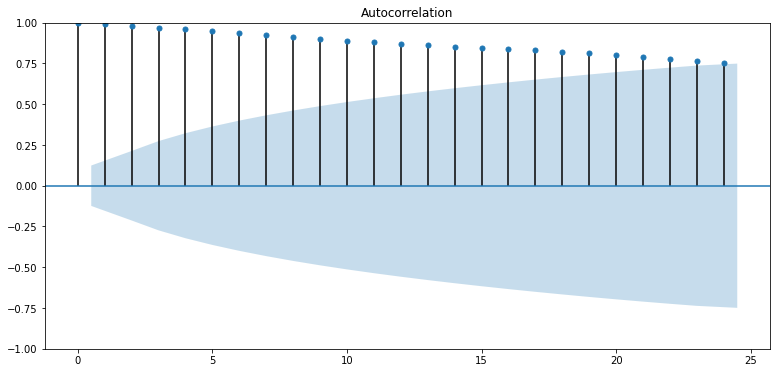

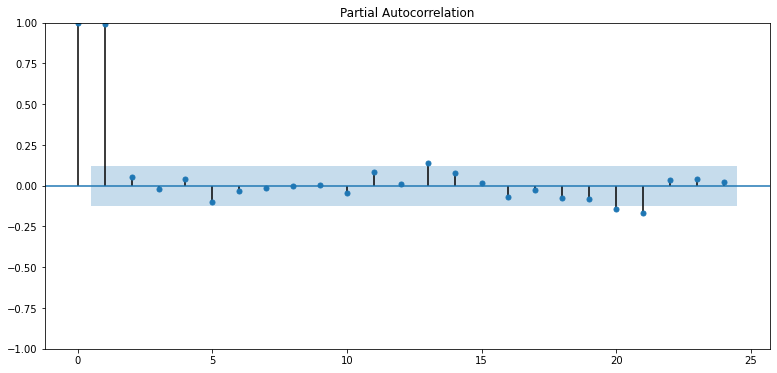

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF : Autocorrelation 그래프 그리기
plot_acf(ts_log)

# PACF : Partial Autocorrelation 그래프 그리기
plot_pacf(ts_log)

plt.show()

`ARIMA` 를 효과적으로 활용하기 위해서는 `ARIMA` 의 모수(parameter)를 잘 설정해야 한다.

`ARIMA` 의 모수는 아래의 3가지가 있다.

1. p : 자기회귀 모형(AR)의 시차

2. d : 차분 누적(I) 횟수

3. q : 이동평균 모형(MA)의 시차


`p` 와 `q` 는 일반적으로 `p + q < 2`, `p * q = 0` 인 값을 사용하는데, 이는 p 나 q 중 하나는 0 이라는 뜻이다.   
많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문이다.

`ARIMA` 의 적절한 모수 `p`, `d`, `q` 를 선택하는 방법으로 많은 통계학적인 시도들이 있지만 대표적인 것으로는

1. ACF(Autocorrelation Function)

2. PACF(Partial Autocorrelation Function)

AutoCorrelation은 우리가 맨 첫 스텝에서 다룬 개념 중 하나인 자기상관계수와 같은 것이다.

**ACF**

- 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수

- 주어진 시계열의 현재 값이 과거 값과 어떻게 상관되는지 설명

- ACF plot에서 X 축은 상관 계수를 나타냄, y축은 시차 수를 나타냄

**PACF**

- **다른 관측치의 영향력을 배제**하고 두 시차의 관측치 간 관련성을 측정하는 함수

- k 이외의 모든 시차를 갖는 관측치의 영향력을 배제한 가운데 특정 두 관측치

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


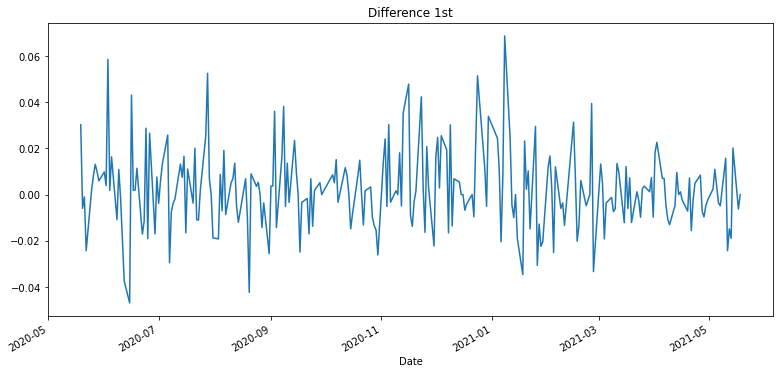

In [25]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


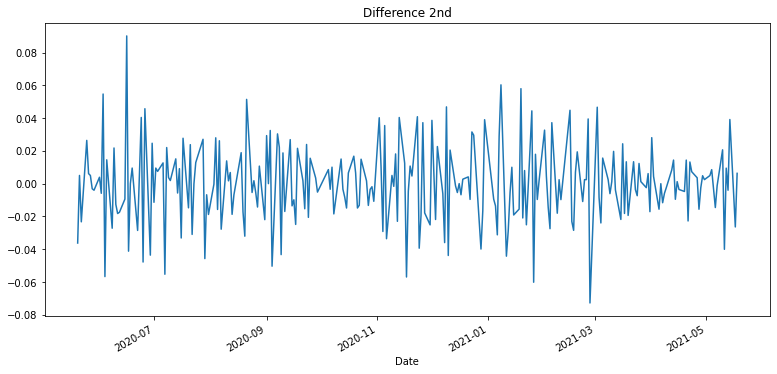

In [26]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [27]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


In [28]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(14, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(14, 1, 0)   Log Likelihood                 587.276
Date:                Thu, 17 Feb 2022   AIC                          -1144.551
Time:                        14:41:10   BIC                          -1093.376
Sample:                             0   HQIC                         -1123.895
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0434      0.067      0.646      0.519      -0.088       0.175
ar.L2         -0.0150      0.080     -0.188      0.851      -0.172       0.141
ar.L3         -0.0398      0.075     -0.529      0.5

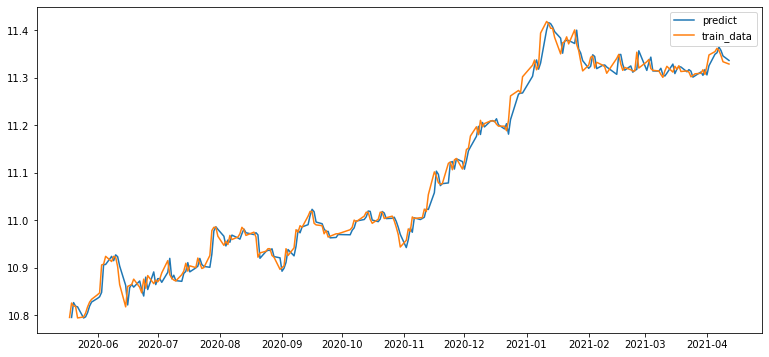

In [29]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

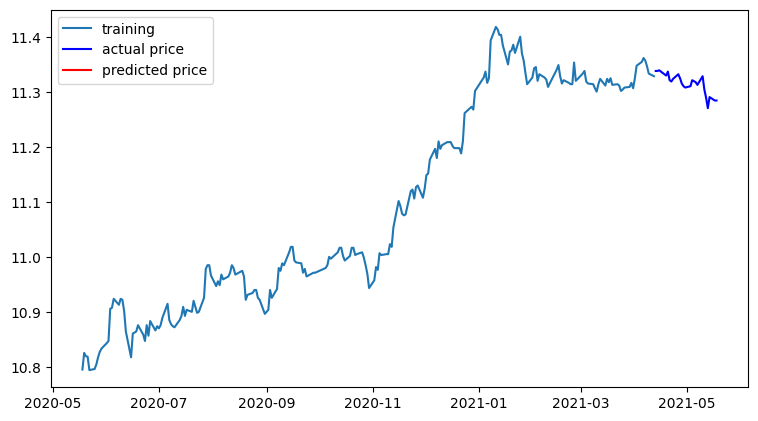

In [30]:
model = ARIMA(train_data, order=(14, 1, 0))  # p값을 14으로 테스트
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차를 계산할 수 있다. 

exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산한다.

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3006527.783454842
MAE:  1233.984501529088
RMSE:  1733.9341923656855
MAPE: nan%


## STEP 7 : 다른 주식 종목 예측해 보기

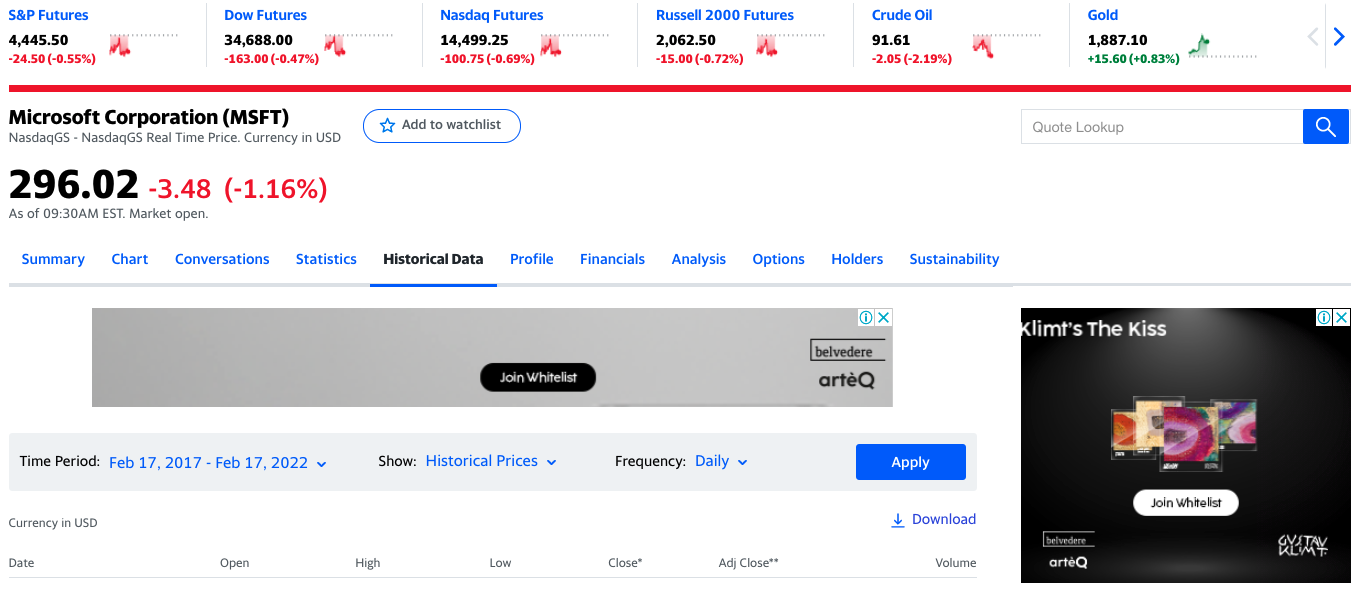

In [32]:
filepath = '/content/drive/MyDrive/AIFFEL/data/stock_prediction/data'

df_MSFT = os.path.join(filepath, 'MSFT.csv')


df_MSFT = pd.read_csv(df_MSFT, index_col='Date', parse_dates=True)

df_MSFT = df_MSFT['Close']

print(type(df_MSFT))
print(df_MSFT.head())

<class 'pandas.core.series.Series'>
Date
2017-02-17    64.620003
2017-02-21    64.489998
2017-02-22    64.360001
2017-02-23    64.620003
2017-02-24    64.620003
Name: Close, dtype: float64


In [33]:
#결측치 처리
df_MSFT = df_MSFT.interpolate(method='time')
df_MSFT[df_MSFT.isna()]

Series([], Name: Close, dtype: float64)

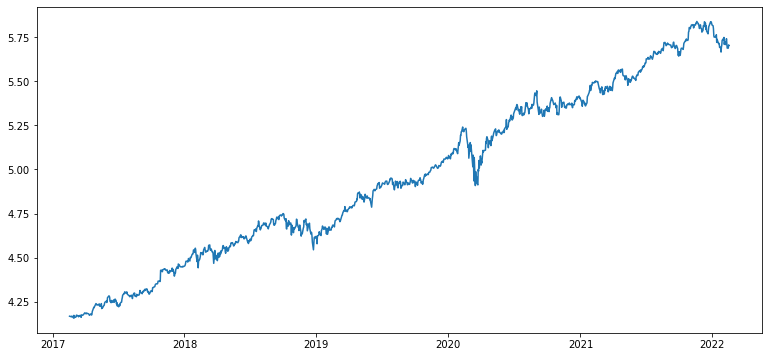

In [34]:
#로그 변환
df_MSFT_log = np.log(df_MSFT)
plt.plot(df_MSFT_log)

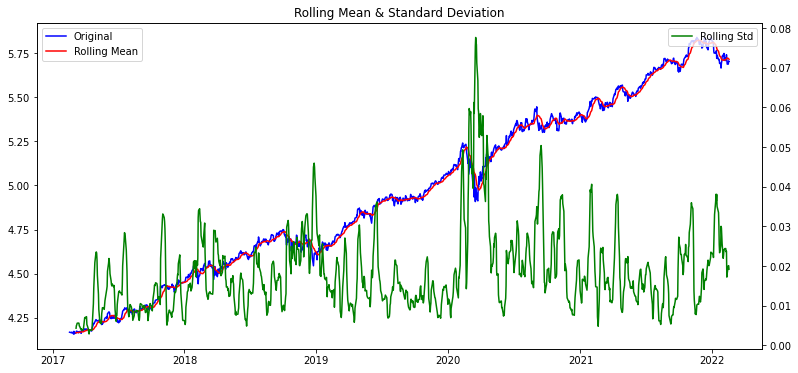

Results of Dickey-Fuller Test:
Test Statistic                   -0.721847
p-value                           0.841009
#Lags Used                        9.000000
Number of Observations Used    1249.000000
Critical Value (1%)              -3.435596
Critical Value (5%)              -2.863857
Critical Value (10%)             -2.568004
dtype: float64


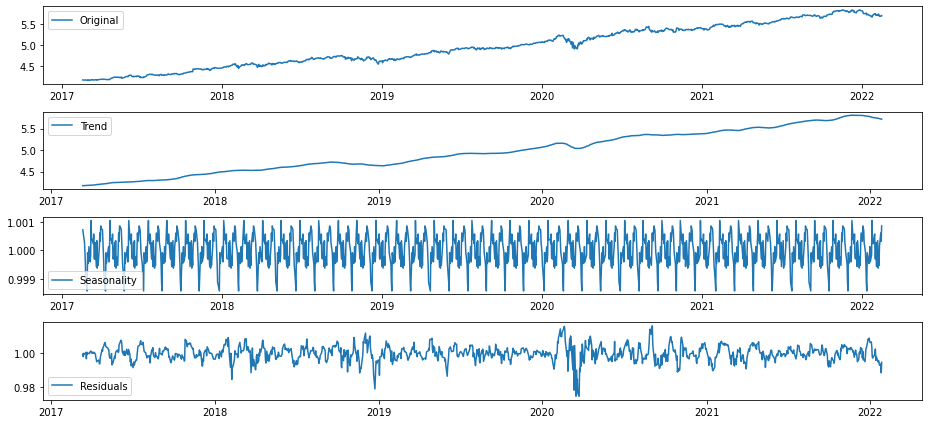

In [35]:
#정성적 그래프 분석
plot_rolling_statistics(df_MSFT_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(df_MSFT_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_MSFT_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_MSFT_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [36]:
#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.131104e+01
p-value                        1.238813e-20
#Lags Used                     1.800000e+01
Number of Observations Used    1.210000e+03
Critical Value (1%)           -3.435766e+00
Critical Value (5%)           -2.863932e+00
Critical Value (10%)          -2.568043e+00
dtype: float64


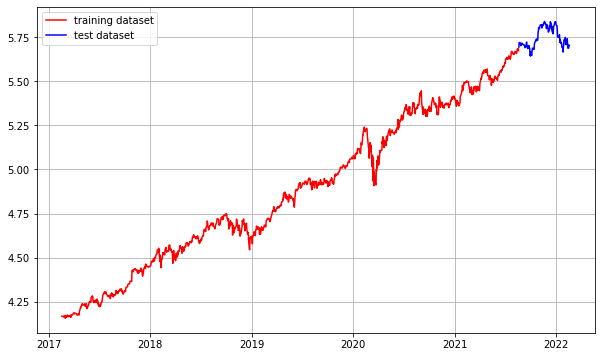

In [37]:
train_data, test_data = df_MSFT_log[:int(len(df_MSFT_log)*0.9)], df_MSFT_log[int(len(df_MSFT_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

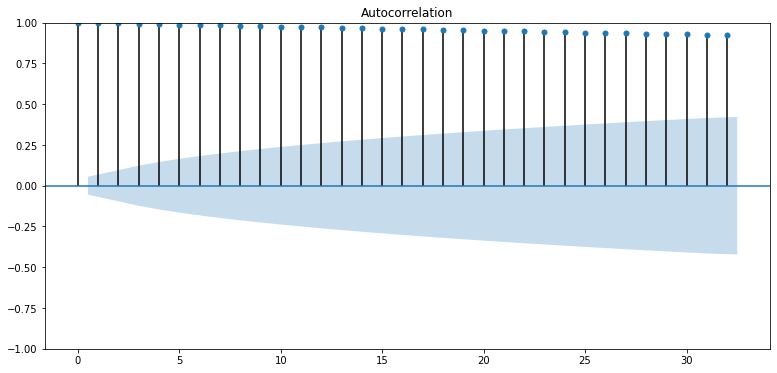

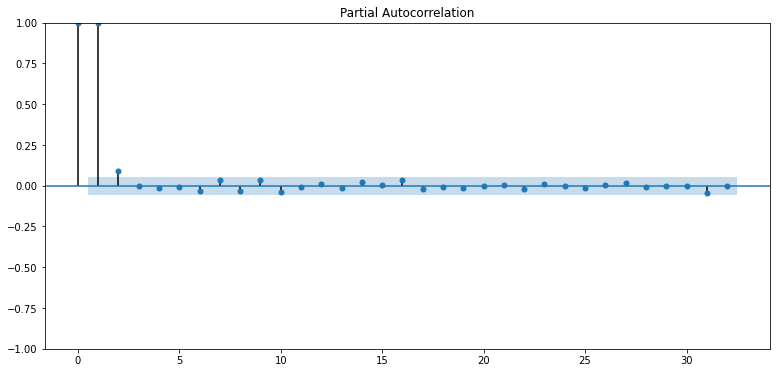

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 적정 ARIMA 모수 찾기
# ACF : Autocorrelation 그래프 그리기
plot_acf(df_MSFT_log)

# PACF : Partial Autocorrelation 그래프 그리기
plot_pacf(df_MSFT_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.202801e+01
p-value                        2.918202e-22
#Lags Used                     8.000000e+00
Number of Observations Used    1.249000e+03
Critical Value (1%)           -3.435596e+00
Critical Value (5%)           -2.863857e+00
Critical Value (10%)          -2.568004e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.547941e+01
p-value                        2.567867e-28
#Lags Used                     1.600000e+01
Number of Observations Used    1.240000e+03
Critical Value (1%)           -3.435635e+00
Critical Value (5%)           -2.863874e+00
Critical Value (10%)          -2.568012e+00
dtype: float64


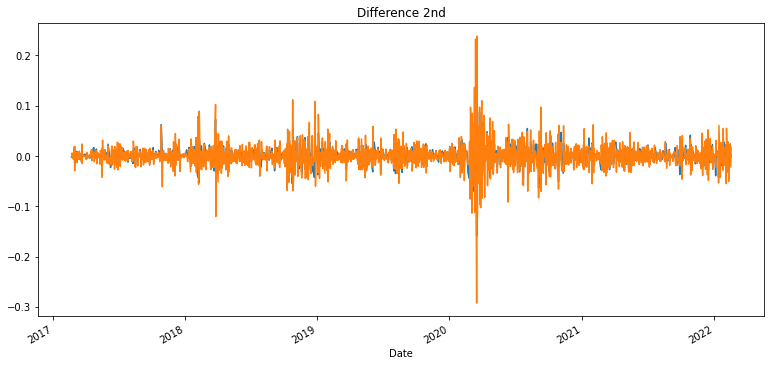

In [39]:
# 1차 차분 구하기
diff_1 = df_MSFT_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [46]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1133
Model:                 ARIMA(2, 0, 1)   Log Likelihood                2996.115
Date:                Thu, 17 Feb 2022   AIC                          -5982.230
Time:                        14:44:51   BIC                          -5957.067
Sample:                             0   HQIC                         -5972.725
                               - 1133                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8769      0.798      6.112      0.000       3.313       6.441
ar.L1          0.8049      0.051     15.910      0.000       0.706       0.904
ar.L2          0.1949      0.051      3.852      0.0

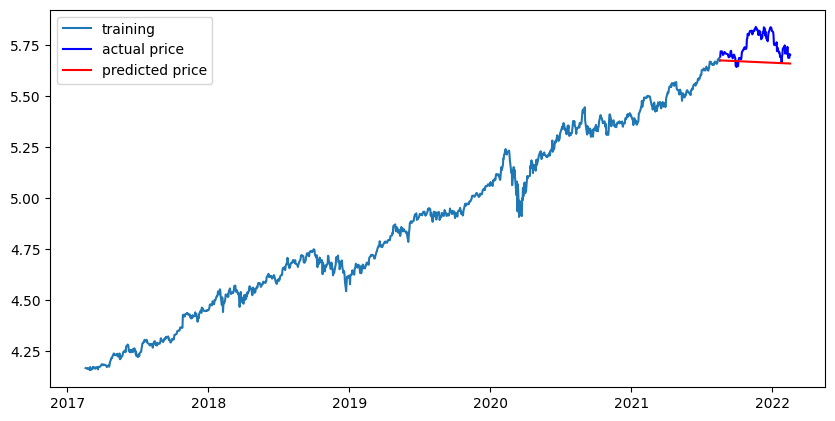

In [47]:
# Forecast : 결과가 fc에 담는다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  915.8693756716102
MAE:  25.01780471430346
RMSE:  30.263333849257425
MAPE: 7.71%


# 🔥 MAPE: 7.71%